## LIBRARIES AND MODULES ##

In [1]:
!pip3 install -U scikit-learn
!pip3 install xgboost

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Combined_set_prescreened (1).csv')
df.head()

MOF  uptake_ads  uptake_des  heat_ads  heat_des  \
0          XUKYEI_neutral    0.920997    0.668303 -21.55231 -18.39099   
1  ja300034j_si_002_clean    0.433112    0.187346 -25.96441 -17.79542   
2          QIYDAF01_clean    0.827077    0.660425 -19.37443 -18.95302   
3            XAHPIH_clean    0.818678    0.634451 -21.96228 -19.54395   
4            VETMIS_clean    0.932519    0.746597 -22.10557 -19.92746   

       LISD      LFSD     LISFS  Unit_cell_volume   Density  ...   O  La  Cr  \
0  13.18217  10.20370  13.18217           6140.00  0.287208  ...   0   0   0   
1  17.49700  17.44104  17.49700           2800.68  0.713223  ...  18   0   0   
2  22.00141  13.48659  22.00141          52812.60  0.303251  ...  96   0   0   
3  14.37026  13.22660  14.37026          12821.80  0.356183  ...  40   0   0   
4  18.13430  11.96931  18.13430          33152.20  0.311959  ...  48   0   0   

   Ti  Ba  Rh  Ce  Cu  Al  Re  
0   0   0   0   0   2   0   0  
1   0   0   0   0   0   0   0  
2   0   0   0   0  24   0   0  
3   0   0   0   0   8   0   0  
4   0   0   0   0  12   0   0  

[5 rows x 111 columns]

## COP CALCULATION ##

In [4]:
df["deltaQ"] = df["uptake_ads"] - df["uptake_des"]
df["deltaHmean"] = (df["heat_ads"] + df["heat_des"])/2
df = df[df["deltaQ"]>=0]
deltaHvap = 16.25 
Tads = 313.15 
Tdes = 358.15
Mw = 44.097/1000
Cp = 1
df["COP"] = (deltaHvap * df["deltaQ"]) / (Mw*Cp*(Tdes - Tads) - df["deltaHmean"]*df["deltaQ"]);

## DATA PREPROCESSING ##

In [5]:
# Dropping columns which are leaky and unnecessary
df.drop(columns=["MOF", "uptake_ads", "uptake_des", "heat_ads", "heat_des", "deltaQ", "deltaHmean"], inplace=True) 

In [6]:
df.dropna(inplace=True) # Dropping NaN values in the dataset
df.drop(columns=["Number_of_pockets.1", "Pu"], inplace=True) # Dropping a duplicate column and a column with only zeros 
df.drop_duplicates(inplace=True) # Dropping all the duplicate rows

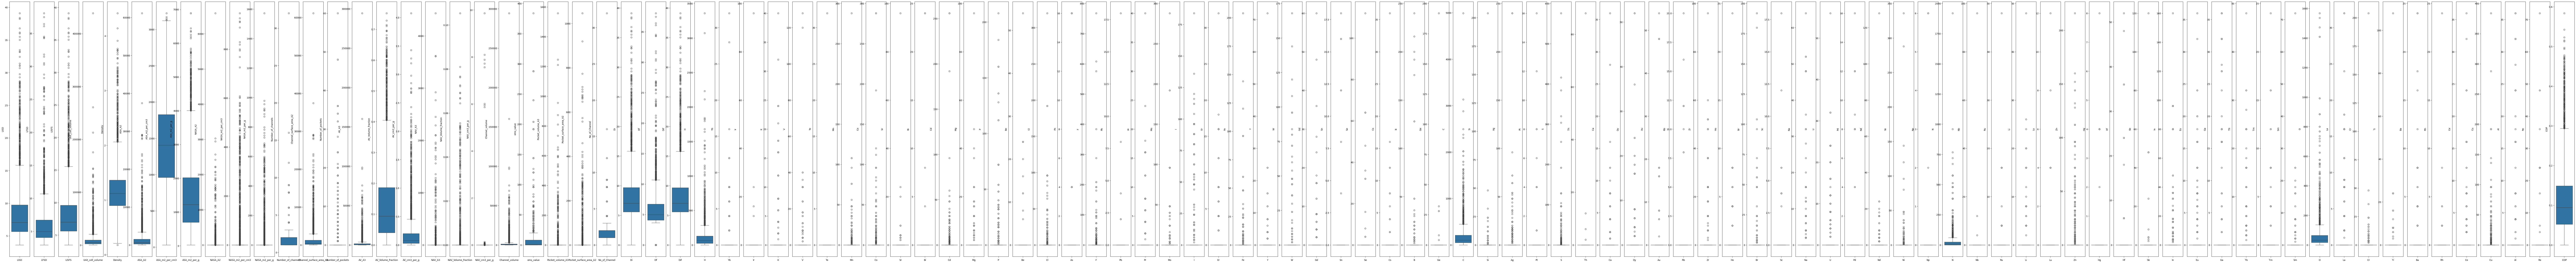

In [7]:
# Box plot to visualize the outliers in the dataset
plt.figure(figsize=(200, 20))
for i, column in enumerate(df.columns, 1):
    plt.subplot(1, len(df.columns), i)
    sns.boxplot(df[column])
    plt.xlabel(column)

In [8]:
# Removing outliers: Considering the data between 5 percentile and 95 percentile
# P5 = df.quantile(0.05)
# P95 = df.quantile(0.95)
# df = df[~((df < P5) | (df > P95)).any(axis=1)]

In [9]:
# Developing a Correlation Matrix
plt.figure(figsize=(200, 50))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [10]:
correlations_with_target = correlation_matrix["COP"].drop("COP")
sorted_correlations = correlations_with_target.sort_values(ascending=False)
plt.figure(figsize=(100, 100))
sorted_correlations.plot(kind='bar', edgecolor='k', alpha=0.7)
plt.title('Correlation of Other Variables with Target')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')

Text(0, 0.5, 'Correlation Coefficient')

In [11]:
high_correlations = correlation_matrix[(correlation_matrix["COP"] >= cutoff) | (correlation_matrix["COP"] <= -cutoff)]
columns_with_high_correlations = high_correlations.index.tolist()
print(columns_with_high_correlations)

['LISD', 'LFSD', 'LISFS', 'Density', 'ASA_m2_per_cm3', 'ASA_m2_per_g', 'AV_Volume_fraction', 'AV_cm3_per_g', 'Di', 'Df', 'Dif', 'COP']


In [12]:
df = df[columns_with_high_correlations]
X = df.drop(columns=["COP"])
y = df["COP"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

## XGradient Boost Regression

In [14]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
xgb_reg = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 243 candidates, totalling 486 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.8, 0.9, 1.0]},
             verbose=2)

In [15]:
best_params = grid_search.best_params_
print(best_params)
best_estimator = grid_search.best_estimator_
y_test_pred = best_estimator.predict(X_test)

{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}


In [16]:
print("R2 score: ", r2_score(y_test, y_test_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE: %f" % (rmse))

R2 score:  0.7871795316076762
RMSE: 0.038200
